In [1]:
!pip install ucimlrepo

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns

plt.style.use('default')
sns.set_palette("tab10")

In [2]:
from ucimlrepo import fetch_ucirepo

optical_recognition_of_handwritten_digits = fetch_ucirepo(id=80)

X = optical_recognition_of_handwritten_digits.data.features
y = optical_recognition_of_handwritten_digits.data.targets

print(optical_recognition_of_handwritten_digits.metadata)

print(optical_recognition_of_handwritten_digits.variables)

X = X.values
y = y.values.ravel()

print(f"\nФорма данных: X {X.shape}, y {y.shape}")
print(f"Уникальные классы: {np.unique(y)}")
print(f"Диапазон значений признаков: [{X.min()}, {X.max()}]")

# Нормализация данных в диапазон [0, 1] для лучшей работы автоэнкодера
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
print(f"Диапазон после нормализации: [{X_scaled.min():.3f}, {X_scaled.max():.3f}]")

{'uci_id': 80, 'name': 'Optical Recognition of Handwritten Digits', 'repository_url': 'https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits', 'data_url': 'https://archive.ics.uci.edu/static/public/80/data.csv', 'abstract': 'Two versions of this database available; see folder', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 5620, 'num_features': 64, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1998, 'last_updated': 'Wed Aug 23 2023', 'dataset_doi': '10.24432/C50P49', 'creators': ['E. Alpaydin', 'C. Kaynak'], 'intro_paper': {'ID': 280, 'type': 'NATIVE', 'title': 'Methods of Combining Multiple Classifiers and Their Applications to Handwritten Digit Recognition', 'authors': 'C. Kaynak', 'venue': 'MSc Thesis, Institute of Graduate Studies in Science and Engineering, 

In [3]:
def create_efficient_autoencoder(encoding_dim, input_dim=64):
    """
    Создает эффективный автоэнкодер с заданной размерностью скрытого слоя
    """
    # Входной слой
    input_layer = Input(shape=(input_dim,))

    # Энкодер
    x = Dense(128, activation='relu')(input_layer)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation='relu')(x)

    # Бутылочное горлышко - главные компоненты
    encoded = Dense(encoding_dim, activation='linear', name='bottleneck')(x)

    # Декодер
    x = Dense(32, activation='relu')(encoded)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)

    # Выходной слой
    decoded = Dense(input_dim, activation='sigmoid')(x)

    # Модели
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)

    # Компиляция с оптимизированными параметрами
    autoencoder.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return autoencoder, encoder

print("Функция создания автоэнкодера определена")

Функция создания автоэнкодера определена


In [4]:
# Создание и обучение автоэнкодера с 2 нейронами

autoencoder_2d, encoder_2d = create_efficient_autoencoder(encoding_dim=2)

# Callbacks для улучшения обучения
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001)
]

print("Архитектура автоэнкодера:")
autoencoder_2d.summary()

# Обучение модели
history_2d = autoencoder_2d.fit(
    X_scaled, X_scaled,
    epochs=100,
    batch_size=128,
    validation_split=0.2,
    shuffle=True,
    callbacks=callbacks,
    verbose=1
)

# Получение закодированных представлений
X_encoded_2d = encoder_2d.predict(X_scaled)
print(f"Закодированные данные (2D): {X_encoded_2d.shape}")

Архитектура автоэнкодера:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 2)              │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,658 (151.01 KB)

 Trainable params: 38,082 (148.76 KB)

 Non-trainable params: 576 (2.25 KB)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.1521 - mae: 0.3435 - val_loss: 0.1423 - val_mae: 0.3525 - learning_rate: 0.0010
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0564 - mae: 0.1796 - val_loss: 0.0999 - val_mae: 0.2901 - learning_rate: 0.0010
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0445 - mae: 0.1495 - val_loss: 0.0798 - val_mae: 0.2483 - learning_rate: 0.0010
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0410 - mae: 0.1387 - val_loss: 0.0681 - val_mae: 0.2179 - learning_rate: 0.0010
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0382 - mae: 0.1312 - val_loss: 0.0615 - val_mae: 0.1971 - learning_rate: 0.0010
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0368 - mae: 0.1275 - val_loss: 0.0548 - val_mae: 0.1792 - learning_rate: 0.0010
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0359 - mae: 0.1250 - val_loss: 0.0496 - val_mae: 0.1639 - learning_rate: 0.0010
Epoch 

In [5]:
# Создание и обучение автоэнкодера с 3 нейронами
print("\n" + "=" * 60)
print("ОБУЧЕНИЕ АВТОЭНКОДЕРА С 3 НЕЙРОНАМИ")
print("=" * 60)

autoencoder_3d, encoder_3d = create_efficient_autoencoder(encoding_dim=3)

history_3d = autoencoder_3d.fit(
    X_scaled, X_scaled,
    epochs=100,
    batch_size=128,
    validation_split=0.2,
    shuffle=True,
    callbacks=callbacks,
    verbose=1
)

# Получение закодированных представлений
X_encoded_3d = encoder_3d.predict(X_scaled)
print(f"Закодированные данные (3D): {X_encoded_3d.shape}")


ОБУЧЕНИЕ АВТОЭНКОДЕРА С 3 НЕЙРОНАМИ
Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.1562 - mae: 0.3515 - val_loss: 0.1411 - val_mae: 0.3509 - learning_rate: 0.0010
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0567 - mae: 0.1829 - val_loss: 0.0986 - val_mae: 0.2882 - learning_rate: 0.0010
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0420 - mae: 0.1458 - val_loss: 0.0780 - val_mae: 0.2476 - learning_rate: 0.0010
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0363 - mae: 0.1306 - val_loss: 0.0652 - val_mae: 0.2159 - learning_rate: 0.0010
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0345 - mae: 0.1250 - val_loss: 0.0565 - val_mae: 0.1914 - learning_rate: 0.0010
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0320 - mae: 0.1184 - val_loss: 0.0491 - val_mae: 0.1716 - learning_rate: 0.0010
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0310 - mae: 0.1154 - val_loss: 0.0444 - val_mae: 0.


ВИЗУАЛИЗАЦИЯ ГЛАВНЫХ КОМПОНЕНТ АВТОЭНКОДЕРА


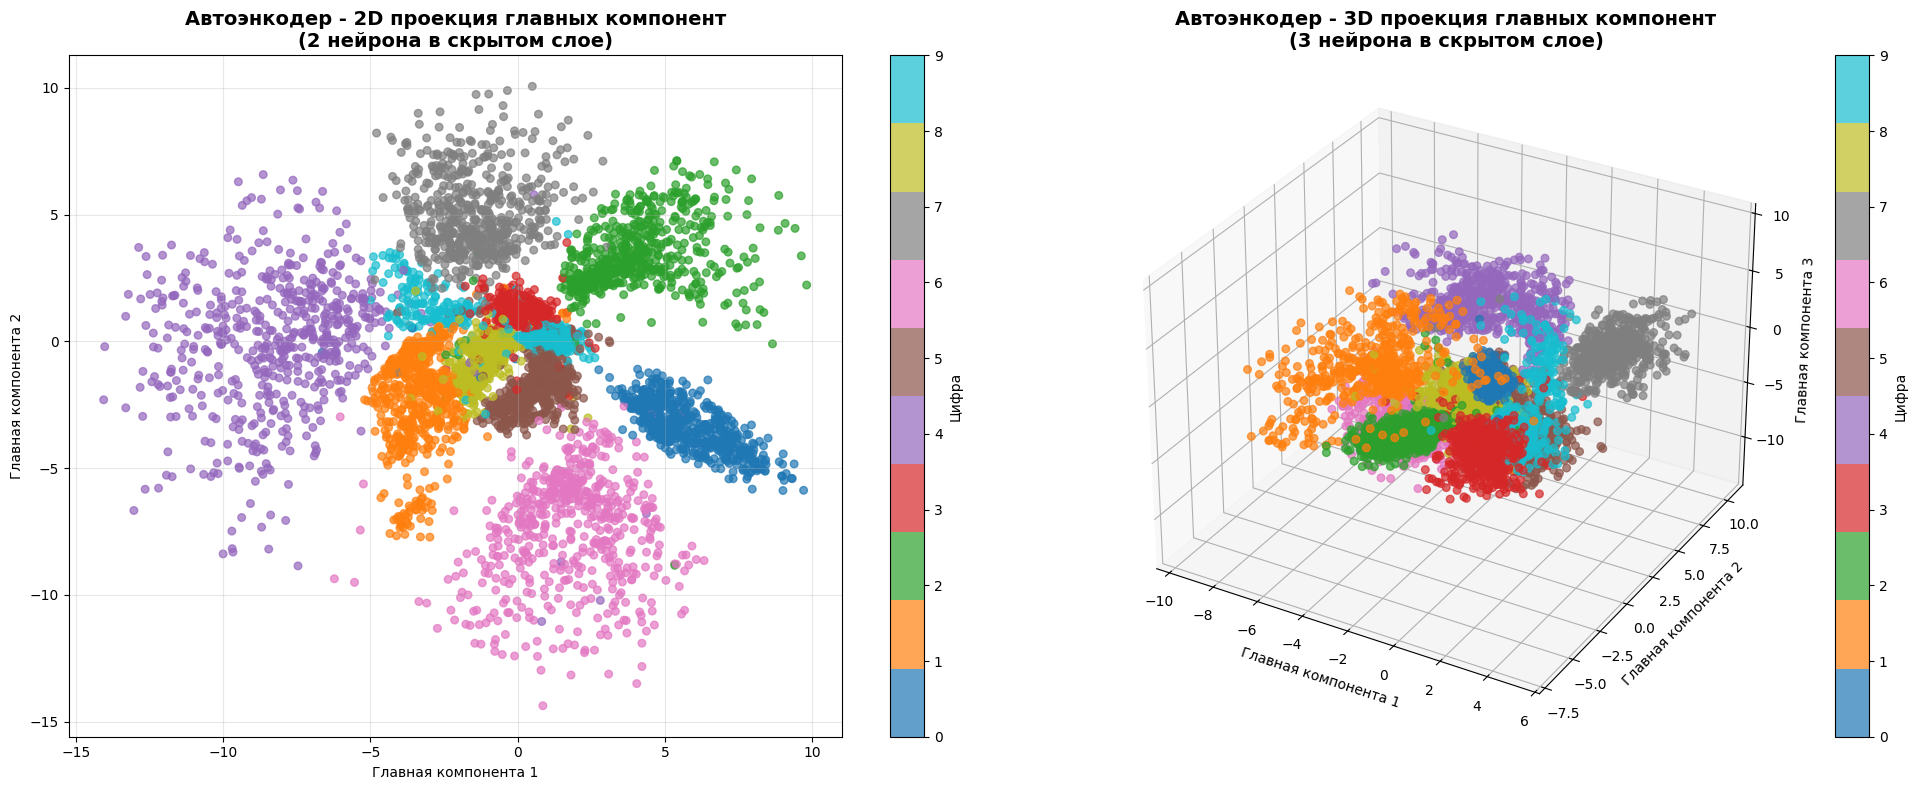

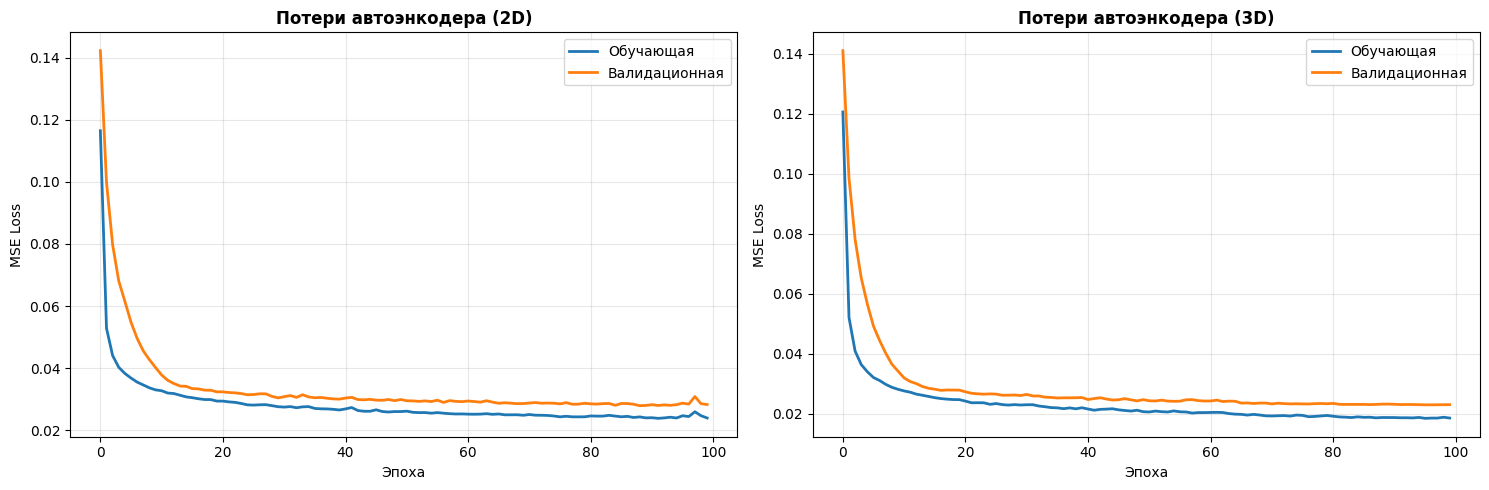

In [6]:
# Визуализация главных компонент автоэнкодера
print("\n" + "=" * 60)
print("ВИЗУАЛИЗАЦИЯ ГЛАВНЫХ КОМПОНЕНТ АВТОЭНКОДЕРА")
print("=" * 60)

fig = plt.figure(figsize=(20, 8))

# 1. 2D проекция автоэнкодера
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_encoded_2d[:, 0], X_encoded_2d[:, 1],
                     c=y, cmap='tab10', alpha=0.7, s=30)
plt.colorbar(scatter, label='Цифра')
plt.title('Автоэнкодер - 2D проекция главных компонент\n(2 нейрона в скрытом слое)',
          fontsize=14, fontweight='bold')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.grid(True, alpha=0.3)

# 2. 3D проекция автоэнкодера
ax = plt.subplot(1, 2, 2, projection='3d')
scatter_3d = ax.scatter(X_encoded_3d[:, 0], X_encoded_3d[:, 1], X_encoded_3d[:, 2],
                       c=y, cmap='tab10', alpha=0.7, s=30)
plt.colorbar(scatter_3d, label='Цифра')
ax.set_title('Автоэнкодер - 3D проекция главных компонент\n(3 нейрона в скрытом слое)',
            fontsize=14, fontweight='bold')
ax.set_xlabel('Главная компонента 1')
ax.set_ylabel('Главная компонента 2')
ax.set_zlabel('Главная компонента 3')

plt.tight_layout()
plt.show()

# Графики обучения
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Потери 2D автоэнкодера
ax1.plot(history_2d.history['loss'], label='Обучающая', linewidth=2)
ax1.plot(history_2d.history['val_loss'], label='Валидационная', linewidth=2)
ax1.set_title('Потери автоэнкодера (2D)', fontweight='bold')
ax1.set_xlabel('Эпоха')
ax1.set_ylabel('MSE Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Потери 3D автоэнкодера
ax2.plot(history_3d.history['loss'], label='Обучающая', linewidth=2)
ax2.plot(history_3d.history['val_loss'], label='Валидационная', linewidth=2)
ax2.set_title('Потери автоэнкодера (3D)', fontweight='bold')
ax2.set_xlabel('Эпоха')
ax2.set_ylabel('MSE Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


ВИЗУАЛИЗАЦИЯ МЕТОДОМ t-SNE
Выполнение t-SNE с 2 компонентами...
Выполнение t-SNE с 3 компонентами...
t-SNE преобразование завершено


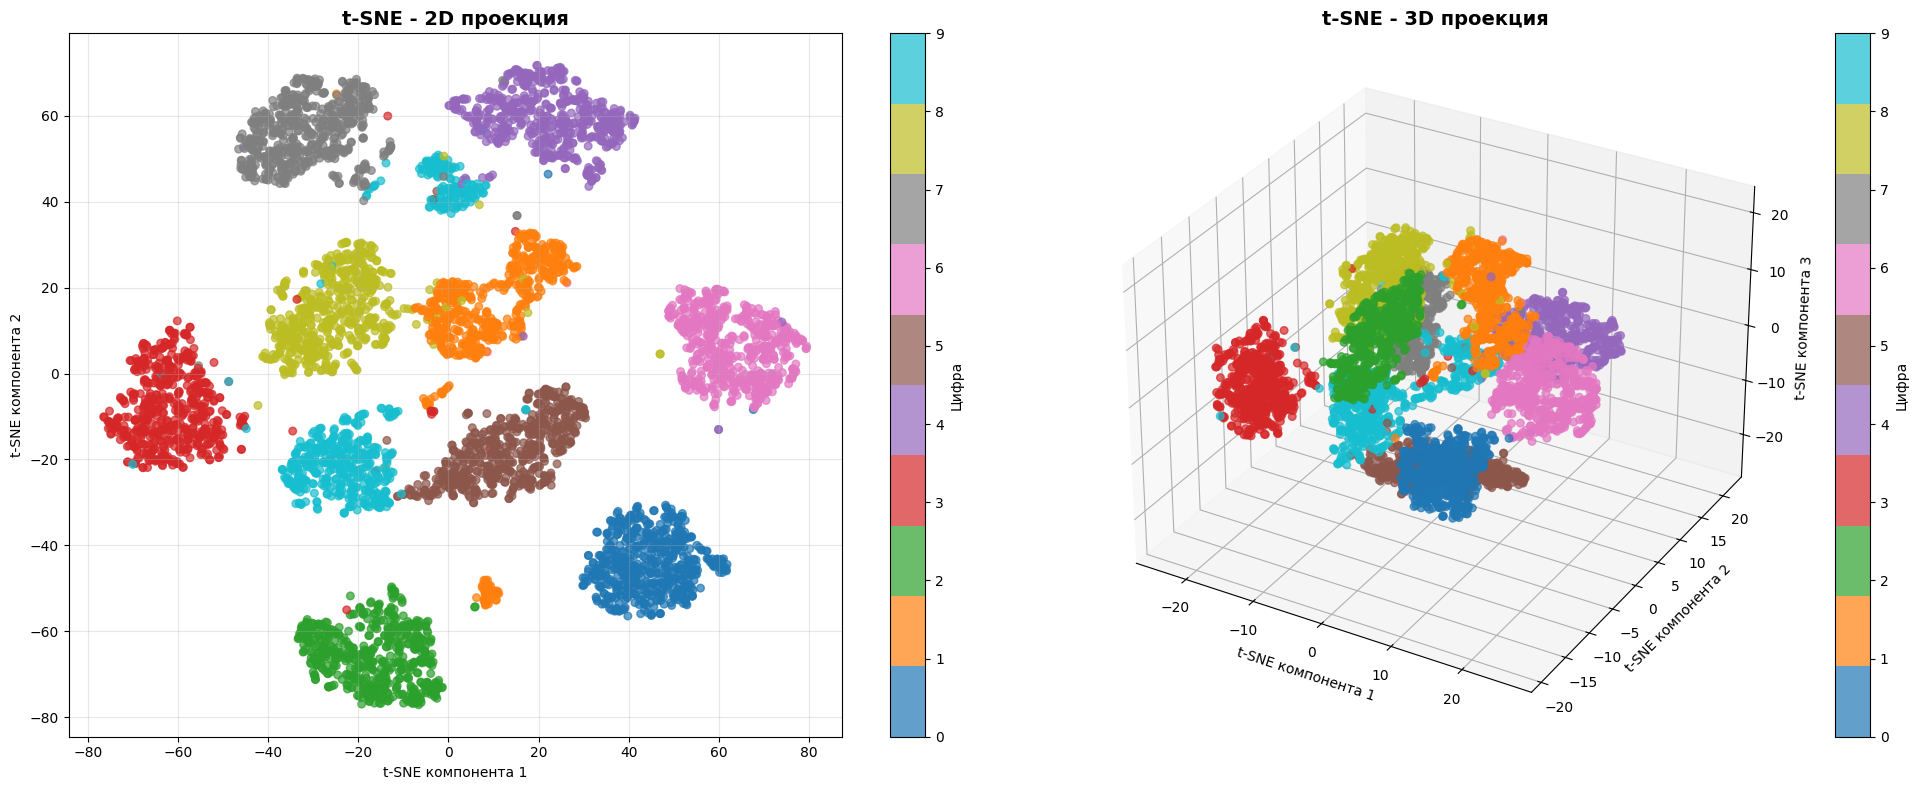

In [7]:
# Реализация t-SNE для визуализации данных
print("\n" + "=" * 60)
print("ВИЗУАЛИЗАЦИЯ МЕТОДОМ t-SNE")
print("=" * 60)

# t-SNE с 2 компонентами (исправленная версия без предупреждений)
print("Выполнение t-SNE с 2 компонентами...")
tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30,
               max_iter=1000, learning_rate=200)  # Заменили n_iter на max_iter
X_tsne_2d = tsne_2d.fit_transform(X_scaled)

# t-SNE с 3 компонентами (исправленная версия без предупреждений)
print("Выполнение t-SNE с 3 компонентами...")
tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30,
               max_iter=1000, learning_rate=200)  # Заменили n_iter на max_iter
X_tsne_3d = tsne_3d.fit_transform(X_scaled)

print("t-SNE преобразование завершено")

# Визуализация t-SNE
fig = plt.figure(figsize=(20, 8))

# 1. 2D t-SNE
plt.subplot(1, 2, 1)
scatter_tsne_2d = plt.scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1],
                             c=y, cmap='tab10', alpha=0.7, s=30)
plt.colorbar(scatter_tsne_2d, label='Цифра')
plt.title('t-SNE - 2D проекция', fontsize=14, fontweight='bold')
plt.xlabel('t-SNE компонента 1')
plt.ylabel('t-SNE компонента 2')
plt.grid(True, alpha=0.3)

# 2. 3D t-SNE
ax = plt.subplot(1, 2, 2, projection='3d')
scatter_tsne_3d = ax.scatter(X_tsne_3d[:, 0], X_tsne_3d[:, 1], X_tsne_3d[:, 2],
                            c=y, cmap='tab10', alpha=0.7, s=30)
plt.colorbar(scatter_tsne_3d, label='Цифра')
ax.set_title('t-SNE - 3D проекция', fontsize=14, fontweight='bold')
ax.set_xlabel('t-SNE компонента 1')
ax.set_ylabel('t-SNE компонента 2')
ax.set_zlabel('t-SNE компонента 3')

plt.tight_layout()
plt.show()


PCA ПРОЕКЦИИ ДЛЯ СРАВНЕНИЯ
Объясненная дисперсия PCA 2D: 0.278
Объясненная дисперсия PCA 3D: 0.398
Объясненная дисперсия по компонентам (2D): [0.14436745 0.13408512]


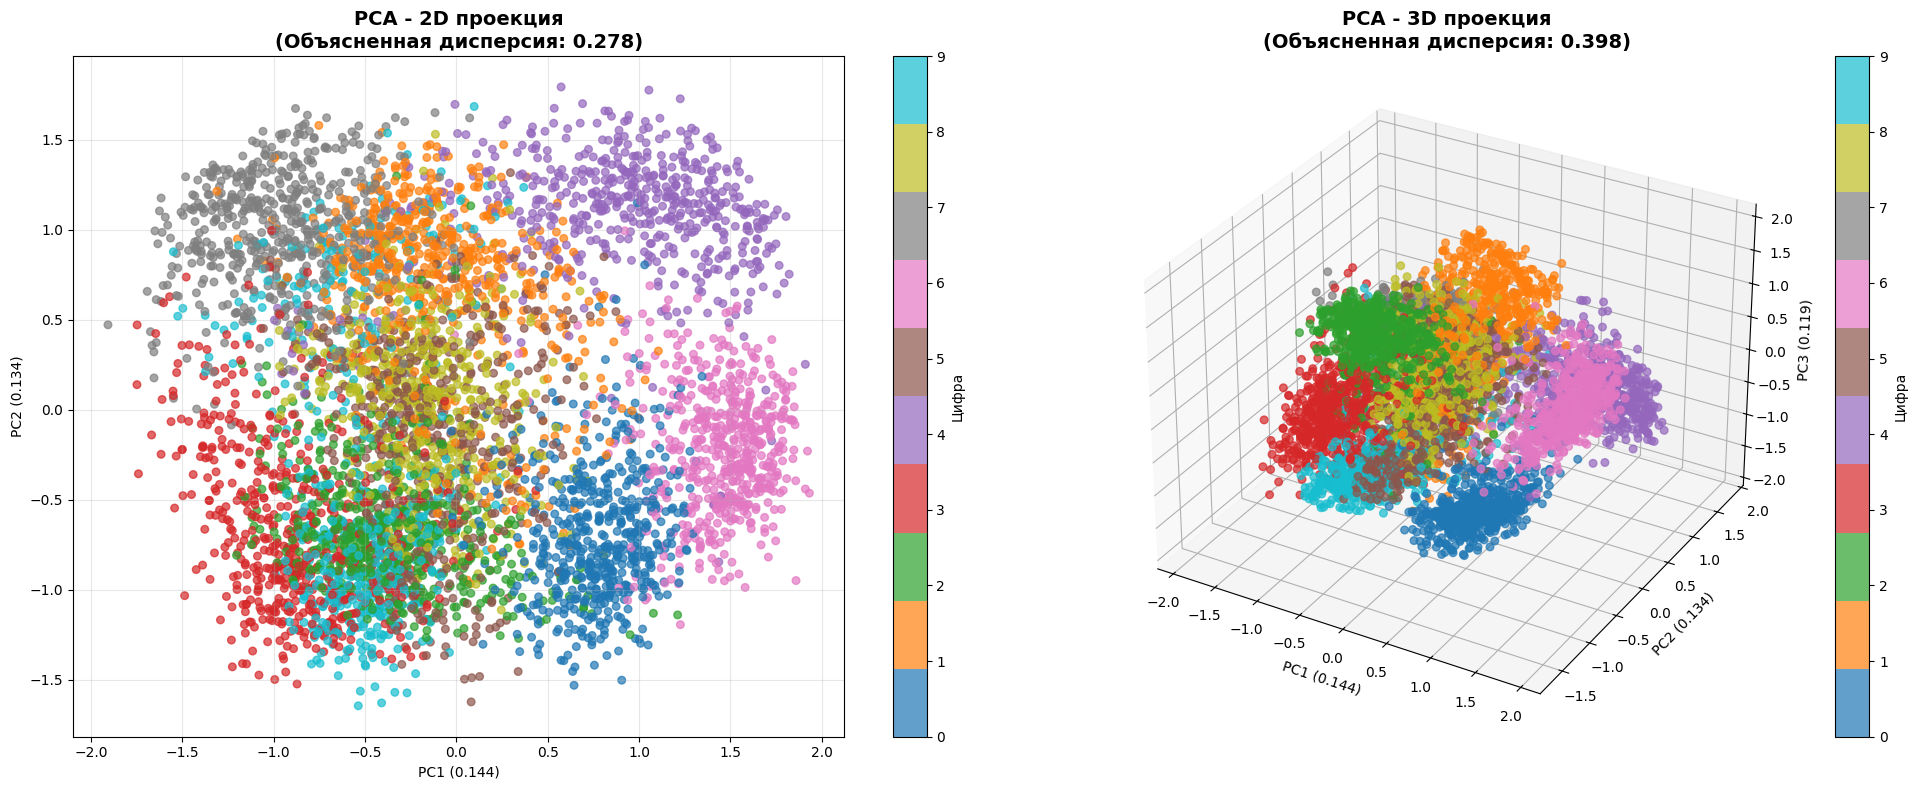

In [8]:
# PCA проекции для сравнения с другими методами
print("\n" + "=" * 60)
print("PCA ПРОЕКЦИИ ДЛЯ СРАВНЕНИЯ")
print("=" * 60)

# PCA с 2 компонентами
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# PCA с 3 компонентами
pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_scaled)

print(f"Объясненная дисперсия PCA 2D: {pca_2d.explained_variance_ratio_.sum():.3f}")
print(f"Объясненная дисперсия PCA 3D: {pca_3d.explained_variance_ratio_.sum():.3f}")
print(f"Объясненная дисперсия по компонентам (2D): {pca_2d.explained_variance_ratio_}")

# Визуализация PCA
fig = plt.figure(figsize=(20, 8))

# 1. PCA 2D
plt.subplot(1, 2, 1)
scatter_pca_2d = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1],
                            c=y, cmap='tab10', alpha=0.7, s=30)
plt.colorbar(scatter_pca_2d, label='Цифра')
plt.title(f'PCA - 2D проекция\n(Объясненная дисперсия: {pca_2d.explained_variance_ratio_.sum():.3f})',
          fontsize=14, fontweight='bold')
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.3f})')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.3f})')
plt.grid(True, alpha=0.3)

# 2. PCA 3D
ax = plt.subplot(1, 2, 2, projection='3d')
scatter_pca_3d = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                           c=y, cmap='tab10', alpha=0.7, s=30)
plt.colorbar(scatter_pca_3d, label='Цифра')
ax.set_title(f'PCA - 3D проекция\n(Объясненная дисперсия: {pca_3d.explained_variance_ratio_.sum():.3f})',
            fontsize=14, fontweight='bold')
ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.3f})')
ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.3f})')
ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.3f})')

plt.tight_layout()
plt.show()